Now comes the hard part. Analyzing the genres section. Unfortunately, pandas dataframes are not meant to hold lists, so we're going to need to be clever about this. 

In [130]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import describe

In [2]:
df = pd.read_csv('../CSVs/7_final_books.csv').drop('Unnamed: 0', axis=1)
df = df[df['genre'] != '[]']

Some research on how to deal with this led me to this excellent article by Max Hilsdorf: 

https://towardsdatascience.com/dealing-with-list-values-in-pandas-dataframes-a177e534f173

Let's try out some of his ideas.

First, I need to see the formatting of my lists.

In [3]:
print(type(df.iloc[0]['genre']))
print(df.iloc[0]['genre'])

<class 'str'>
['Science Fiction', 'Fiction', 'Fantasy', 'Queer', 'LGBT', 'Adult', 'Time Travel']


As expected, pandas has put this lists into the form of a string. But there is one relief--each element is surrounded by quotation marks. That should make things a bit easier! 

In [4]:
df['genre'] = df['genre'].apply(eval)

In [5]:
print(type(df.iloc[0]['genre']))
print(df.iloc[0]['genre'])

<class 'list'>
['Science Fiction', 'Fiction', 'Fantasy', 'Queer', 'LGBT', 'Adult', 'Time Travel']


Wonderful! Each book's genre feature is now treated as a list! Now we just need to find the counts--ideally without looping through all 22,000 data points. Hilsdorf recommends we consider the column as a 2D array, and then convert it to a 1D array. 

In [6]:
def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

In [7]:
all_genres = to_1D(df['genre'])

In [8]:
all_genres.head(10)

0    Science Fiction
1            Fiction
2            Fantasy
3              Queer
4               LGBT
5              Adult
6        Time Travel
7    Science Fiction
8            Mystery
9            Fiction
dtype: object

In [9]:
print(f"Our {len(df)} books have a total of {len(all_genres)} genres.\
 An average of {round(len(all_genres)/len(df), 1)} genres per book.")

Our 22022 books have a total of 131598 genres. An average of 6.0 genres per book.


Now that the genre column is correctly interpreted as a list, we can get more specific by adding a column for the number of genres each book has. 

In [10]:
df['num genres'] = df['genre'].apply(lambda x: len(x))

In [11]:
df.head()

,title,author,total words,vividness,passive voice,all adverbs,ly-adverbs,non-ly-adverbs,genre,year,num genres
0,The Vanished Birds,Simon Jimenez,124205.0,55.18,6.37,1.95,0.36,1.58,"[Science Fiction, Fiction, Fantasy, Queer, LGB...",2020.0,7
1,The Price of Honor,Jonathan P. Brazee,77253.0,35.35,8.71,2.63,0.71,1.92,[Science Fiction],2017.0,1
2,The Case of the Baker Street Irregulars,Anthony Boucher,80557.0,32.33,8.41,3.72,1.64,2.08,"[Mystery, Fiction, Crime, Humor, Classics, 20t...",1940.0,7
3,Wildoak,C. C. Harrington,55602.0,74.34,6.92,3.04,1.16,1.87,"[Middle Grade, Historical Fiction, Fiction, An...",2022.0,7
4,The Holiday,T. M. Logan,101767.0,50.30,8.02,3.06,1.12,1.93,"[Thriller, Mystery, Fiction, Mystery Thriller,...",2019.0,7


Next, let's see which genres are most common. I know from inspection that many of the elements classed as genres are actually not categories that would generally be considered genres--elements like "Australia," or "Star Trek." I'd anticipate finding these near the bottom for number of books. This is likely because Goodreads genres are generated by how users shelve their own books. 

In [12]:
len(all_genres.value_counts())

688

All in all, we have nearly 700 distinct supposed "genres!" Definitely too many to try to classify from only 22,000 books. Time to start finding ones to eliminate! 

In [13]:
all_genres.value_counts().head()

Fiction      15167
Mystery       7840
Thriller      6067
Fantasy       5670
Audiobook     5477
Name: count, dtype: int64

As it turns out, one of the top 5 "genres" is, in fact, not a genre--"Audiobook" is a format. It looks like not all the "genres" we need to get rid of will be close to the bottom! 

Still, it might be worth checking the singletons.

In [14]:
np.sum(all_genres.value_counts() == 1)

117

It seems that over a hundred of the "genres" appear only once in the entire dataframe! Let's expand our net even more. 

In [15]:
np.sum(all_genres.value_counts() <= 10)

333

Wow! Just about half of the genres appear in fewer than 10 books. 

Out of curiosity, let's see what some of the singletons look like.

In [16]:
genres_df = pd.DataFrame(all_genres.value_counts())

In [17]:
genres_df[genres_df['count'] == 1].head(10)

,count
Mauritius,1
Paranormal Urban Fantasy,1
Victorian Romance,1
Transport,1
Wonder Woman,1
Romanian Literature,1
Golden Age Mystery,1
Romanticism,1
Spider Man,1
Georgian,1


Here we can see locations, time periods, overly-specific combination genres, topics, and even two characters. 

In [18]:
genres_df[genres_df['count'] == 1].tail(10)

,count
M M Sports Romance,1
Mysticism,1
Green,1
M M Mystery,1
American Fiction,1
Banks,1
Cthulhu Mythos,1
Prayer,1
Bigfoot,1
Romania,1


These patterns continue at the bottom of the list. None of these are good candidates for classification, and can easily be removed. 

Let's check genres with 10 books.

In [19]:
genres_df[genres_df['count'] == 10].head(10)

,count
Terrorism,10
Academic,10
Ecology,10
Ukraine,10
Birds,10
Social Issues,10
Category Romance,10
Chapter Books,10
Fitness,10
Read For School,10


These do indeed follow similar patterns! Mostly topics, genres, formats, and "read for school," which is simply the way people shelve their books. 

Let's try approaching this from the opposite direciton. How many genres have at least 1000 books? 

In [20]:
print(f"{len(genres_df[genres_df['count'] >= 1000])} genres have more than 1000 books.")
genres_df[genres_df['count'] >= 1000]

27 genres have more than 1000 books.


,count
Fiction,15167
Mystery,7840
Thriller,6067
Fantasy,5670
Audiobook,5477
Mystery Thriller,3934
Crime,3765
Science Fiction,3483
Contemporary,3328
Romance,3234


The most comon, by far, is Fiction, with more than half of our dataset. It could be argued whether this represents a "genre" at all, and it may or may not be a useful classification. 

"Audiobook" is certainly not a genre, and "Mystery Thriller" appears to be a combination of two larger genres, "Mystery" and "Thriller." 

In [21]:
#Number of books with the genre "Mystery Thriller" (as seen above)
len(df[df['genre'].apply(lambda x: "Mystery Thriller" in x)])

3934

In [22]:
#Number of books with both the genre "Mystery Thriller" and the genre "Mystery"
len(df[df['genre'].apply(lambda x: ("Mystery Thriller" in x) & ("Mystery" in x))])

3774

In [23]:
#Number of books with both the genre "Mystery Thriller" and the genre "Thriller"
len(df[df['genre'].apply(lambda x: ("Mystery Thriller" in x) & ("Thriller" in x))])

3342

In [24]:
#Number of books with all three genres, "Mystery Thriller", "Mystery", and "Thriller"
len(df[df['genre'].apply(lambda x: ("Mystery Thriller" in x) & ("Thriller" in x) & ("Mystery" in x))])

3220

In [25]:
3220/3934

0.8185053380782918

Sure enough, there's more than an 80% overlap in "Mystery Thriller" and both of the other genres. So "Mystery Thriller" is mostly redundant and can be removed--or at least replaced with both Mystery and Thriller. 

The rest require some domain knowledge. Is "Magic" a genre? Are "Novels" a genre seperate from Fiction? Are most of the books in other genres actually novels without mentioning it?

It might be useful to check the correlations between these. Surely there's a way this can be done! 

In [26]:
top_genres = genres_df[genres_df['count']>=900].reset_index()

In [27]:
corr = np.ones(shape=(len(top_genres), len(top_genres)))

In [28]:
for i in range(1, len(top_genres)):
    for j in range(i):
        genre_i = top_genres.iloc[i]['index']
        genre_j = top_genres.iloc[j]['index']
        count_i = len(df[df['genre'].apply(lambda x: genre_i in x)])
        count_j = len(df[df['genre'].apply(lambda x: genre_j in x)])
        count_both = len(df[df['genre'].apply(lambda x: (genre_i in x) & (genre_j in x))])
        corr[i][j] = count_both/count_i
        corr[j][i] = count_both/count_j

In [29]:
top_genres.iloc[0]['index']

'Fiction'

In [30]:
corr = pd.DataFrame(corr)

In [31]:
corr.columns = top_genres['index']

In [32]:
corr.index = top_genres['index']

In [33]:
corr.style.background_gradient()

index,Fiction,Mystery,Thriller,Fantasy,Audiobook,Mystery Thriller,Crime,Science Fiction,Contemporary,Romance,Nonfiction,Suspense,Historical Fiction,Adult,Young Adult,Historical,Horror,Adventure,Paranormal,History,Literary Fiction,Science Fiction Fantasy,Magic,Novels,Biography,Classics,LGBT,Memoir,Short Stories
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Fiction,1.000000,0.451045,0.358278,0.280345,0.286807,0.245797,0.217182,0.186919,0.197732,0.150722,0.000000,0.180919,0.174458,0.156458,0.137206,0.112547,0.089273,0.075427,0.042065,0.000000,0.078658,0.073976,0.049581,0.072130,0.000000,0.061779,0.048856,0.000000,0.051230
Mystery,0.872577,1.000000,0.628316,0.097577,0.290689,0.481378,0.433036,0.055867,0.139796,0.082908,0.004082,0.344770,0.135969,0.102041,0.081122,0.091709,0.086990,0.046939,0.048214,0.002551,0.020536,0.010332,0.014413,0.023087,0.001148,0.036480,0.019005,0.001020,0.019643
Thriller,0.895665,0.811933,1.000000,0.061645,0.320092,0.550849,0.453766,0.080930,0.128400,0.040547,0.002143,0.434811,0.064282,0.107796,0.047140,0.029998,0.116038,0.054557,0.027031,0.001648,0.013186,0.009890,0.001319,0.024065,0.000659,0.008241,0.017307,0.000330,0.020438
Fantasy,0.749912,0.134921,0.065961,1.000000,0.171781,0.012169,0.011111,0.337566,0.047443,0.231217,0.000000,0.010229,0.117989,0.149030,0.289947,0.072840,0.133510,0.118871,0.189065,0.000000,0.018695,0.156614,0.195414,0.027337,0.000000,0.047090,0.085714,0.000000,0.061905
Audiobook,0.794230,0.416104,0.354574,0.177835,1.000000,0.269673,0.219281,0.137667,0.204674,0.130729,0.171444,0.187877,0.114661,0.188424,0.067555,0.084170,0.051488,0.046376,0.024283,0.054044,0.072668,0.055505,0.035969,0.029578,0.080701,0.015337,0.025561,0.084718,0.040898
Mystery Thriller,0.947636,0.959329,0.849517,0.017539,0.375445,1.000000,0.524911,0.027453,0.136756,0.038638,0.000254,0.516014,0.063803,0.121505,0.051601,0.033045,0.064311,0.019319,0.014489,0.000254,0.012201,0.001017,0.000508,0.014743,0.000000,0.023386,0.014743,0.000000,0.015760
Crime,0.874900,0.901726,0.731208,0.016733,0.318991,0.548473,1.000000,0.016733,0.074635,0.028685,0.026029,0.367596,0.087649,0.052058,0.018592,0.060823,0.040372,0.020983,0.006906,0.015936,0.008234,0.003187,0.002125,0.020186,0.011155,0.030013,0.012483,0.007703,0.021780
Science Fiction,0.813953,0.125754,0.140970,0.549526,0.216480,0.031008,0.018088,1.000000,0.036750,0.078668,0.000000,0.032156,0.048808,0.111111,0.167959,0.018375,0.130060,0.109101,0.031582,0.000000,0.016078,0.241459,0.034166,0.058857,0.000000,0.059432,0.068045,0.000000,0.079816
Contemporary,0.901142,0.329327,0.234075,0.080829,0.336839,0.161659,0.084435,0.038462,1.000000,0.389724,0.009014,0.127704,0.093450,0.279748,0.134916,0.032452,0.029447,0.007512,0.029447,0.000601,0.245793,0.001803,0.005108,0.145433,0.003906,0.015024,0.075120,0.006310,0.046274


![correlations heatmap](Genre_heatmap.png)

To interpret this dataframe, each cell represents the percentage of the row genre that also belongs to the colum genre. 

For example, the left column represents the percentage of each genre that also has the Fiction tag. The top row represents the percentage of Fiction-tagged books that also have each other genre. 

So, looking just at the 4 boxes in the upper-lefthand corner, 100% of Fiction is Fiction and 100% of Mystery is Mystery (of course), but also, 87% of Mystery is Fiction, and 45% of Fiction is Mystery. (This surprisingly large number is likely a consequence of the preponderance of Hardy Boys and Nancy Drew novels in the dataset).

The darker colors near the left and on the top make sense, since the genres is sorted in order of frequency. 

### Analysis 

Nearly everything is highly correlated with Fiction, except Nonfiction, History, and Biography, none of which ever coexist in the same book. This is promising for the accuracy of our data! But it also means that a classification for Fiction is likely redundant. 

98% of Magic books fall under Fantasy, and Magic will likely be dropped. . 

75% of Science Fiction Fantasy is Fantasy, and 70% of Science Fiction Fantasy is Science Fiction. So we can likely break up Science Fiction Fantasy into its component parts. 

Now that we have some insight into features to drop, let's try actually dropping some. Let's say that we end up keeping exactly the features with more than 1000 books. 

In [34]:
def filter_genres(genres, keep):
    filtered = [genre for genre in genres if genre in keep]
    return filtered

In [35]:
# Create an array of the top genres
keep_genres = top_genres['index'].values

In [36]:
# Create a new column on our dataframe with only the top genres
df['filtered genres'] = df['genre'].apply(lambda x: filter_genres(x, keep_genres))

In [37]:
df.head()

,title,author,total words,vividness,passive voice,all adverbs,ly-adverbs,non-ly-adverbs,genre,year,num genres,filtered genres
0,The Vanished Birds,Simon Jimenez,124205.0,55.18,6.37,1.95,0.36,1.58,"[Science Fiction, Fiction, Fantasy, Queer, LGB...",2020.0,7,"[Science Fiction, Fiction, Fantasy, LGBT, Adult]"
1,The Price of Honor,Jonathan P. Brazee,77253.0,35.35,8.71,2.63,0.71,1.92,[Science Fiction],2017.0,1,[Science Fiction]
2,The Case of the Baker Street Irregulars,Anthony Boucher,80557.0,32.33,8.41,3.72,1.64,2.08,"[Mystery, Fiction, Crime, Humor, Classics, 20t...",1940.0,7,"[Mystery, Fiction, Crime, Classics]"
3,Wildoak,C. C. Harrington,55602.0,74.34,6.92,3.04,1.16,1.87,"[Middle Grade, Historical Fiction, Fiction, An...",2022.0,7,"[Historical Fiction, Fiction, Young Adult]"
4,The Holiday,T. M. Logan,101767.0,50.30,8.02,3.06,1.12,1.93,"[Thriller, Mystery, Fiction, Mystery Thriller,...",2019.0,7,"[Thriller, Mystery, Fiction, Mystery Thriller,..."


In [38]:
# Create a new column with the number of genres from the allowed list in each book
df['num filtered genres'] = df['filtered genres'].apply(lambda x: len(x))

In [39]:
df.head()

,title,author,total words,vividness,passive voice,all adverbs,ly-adverbs,non-ly-adverbs,genre,year,num genres,filtered genres,num filtered genres
0,The Vanished Birds,Simon Jimenez,124205.0,55.18,6.37,1.95,0.36,1.58,"[Science Fiction, Fiction, Fantasy, Queer, LGB...",2020.0,7,"[Science Fiction, Fiction, Fantasy, LGBT, Adult]",5
1,The Price of Honor,Jonathan P. Brazee,77253.0,35.35,8.71,2.63,0.71,1.92,[Science Fiction],2017.0,1,[Science Fiction],1
2,The Case of the Baker Street Irregulars,Anthony Boucher,80557.0,32.33,8.41,3.72,1.64,2.08,"[Mystery, Fiction, Crime, Humor, Classics, 20t...",1940.0,7,"[Mystery, Fiction, Crime, Classics]",4
3,Wildoak,C. C. Harrington,55602.0,74.34,6.92,3.04,1.16,1.87,"[Middle Grade, Historical Fiction, Fiction, An...",2022.0,7,"[Historical Fiction, Fiction, Young Adult]",3
4,The Holiday,T. M. Logan,101767.0,50.30,8.02,3.06,1.12,1.93,"[Thriller, Mystery, Fiction, Mystery Thriller,...",2019.0,7,"[Thriller, Mystery, Fiction, Mystery Thriller,...",7


For reference, let's look at the description of the original genres list.

In [40]:
df['num genres'].describe()

count    22022.000000
mean         5.975752
std          1.884849
min          1.000000
25%          6.000000
50%          7.000000
75%          7.000000
max          7.000000
Name: num genres, dtype: float64

Some books had only 1 genre, but 75% of the books had at least 6, and at least half had the maximum number I scraped from goodreads--7. 

Now let's see what happens after I remove every genre except the top ones.

In [41]:
df['num filtered genres'].describe()

count    22022.000000
mean         4.053764
std          1.774954
min          0.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          7.000000
Name: num filtered genres, dtype: float64

Now are mean has gone from around 6 to around 4, and the median has decreased all the way from 7 to 4. However, most books still have genres left. 

Let's see which books have lost all of their genres. I'll use a sample of the first and last 5 of those books.

In [42]:
lost_genres = df[df['num filtered genres'] == 0]
print(f"{len(lost_genres)} books no longer have any genres left. Here are some of them:")
pd.concat([lost_genres.head(),lost_genres.tail()])

211 books no longer have any genres left. Here are some of them:


,title,author,total words,vividness,passive voice,all adverbs,ly-adverbs,non-ly-adverbs,genre,year,num genres,filtered genres,num filtered genres
353,Startup Mixology,Frank Gruber,61170.0,19.85,7.47,2.81,1.00,1.81,"[Business, Entrepreneurship, Technology]",2014.0,3,[],0
492,Turbulent Wake,Paul E. Hardisty,84687.0,64.52,6.67,2.44,0.52,1.93,[Canada],2019.0,1,[],0
773,From Shy Guy To Ladies Man,Chris Bale,23616.0,28.81,7.85,4.16,1.89,2.27,[Self Help],2016.0,1,[],0
1111,One Step Ahead,Audrey Walker,19968.0,28.98,10.51,3.49,0.93,2.56,[Psychological Thriller],2021.0,1,[],0
1124,Dawn of Chaos,Daniel Willcocks & Michael Anderle,74595.0,51.85,7.20,2.93,1.02,1.92,[Zombies],2018.0,1,[],0
21729,The Outer Dark,Zachary Rawlins,203197.0,48.58,6.94,3.56,1.72,1.84,[Urban Fantasy],2017.0,1,[],0
21772,Endurance,Brunoo Miller,42029.0,43.12,8.19,2.82,1.00,1.82,[Dystopia],2019.0,1,[],0
21825,Emperor of the Earth,Czeslaw Milosz,87103.0,21.72,6.22,2.94,1.13,1.81,"[Poetry, Poland, Criticism, Essays]",1977.0,4,[],0
21833,Blue Moon,Jessica Saren,24065.0,50.20,6.61,3.44,1.73,1.72,[Reverse Harem],2018.0,1,[],0
22129,How To Have Kick-Ass Ideas,Chris Baréz-Brown,28957.0,26.86,8.99,4.20,1.14,3.06,[Business],2008.0,1,[],0


In [43]:
lost_genres['num genres'].describe()

count    211.000000
mean       1.464455
std        0.927062
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        7.000000
Name: num genres, dtype: float64

Most of the books that have lost all their genres had only 1 genre tag originally, and it did not happen to be a popular one. But at least some unlucky books had 7 genres, and none of them were winners.

In [44]:
lost_genres[lost_genres['num genres'] == 7]

,title,author,total words,vividness,passive voice,all adverbs,ly-adverbs,non-ly-adverbs,genre,year,num genres,filtered genres,num filtered genres
20233,Coming Home,Laurèn Lee,60114.0,57.65,6.2,2.87,0.98,1.89,"[Comics, Graphic Novels, Marvel, Spider Man, C...",2001.0,7,[],0


In [45]:
df.iloc[20233]['genre']

['Comics',
 'Graphic Novels',
 'Marvel',
 'Spider Man',
 'Comic Book',
 'Superheroes',
 'Graphic Novels Comics']

Looks like there was just one book this unlucky--a Spider-Man comic. 

Next, let's try splitting up the combination genres--Science Fiction Fantasy into Science Fiction and Fantasy, and Mystery Thriller into Mystery and Thriller.

In [46]:
def split_genres(genres):
    
    # So we don't change the original list
    split = genres.copy()
    
    if "Science Fiction Fantasy" in genres: 
        split.remove("Science Fiction Fantasy")
        split.append("Science Fiction")
        split.append("Fantasy")
        
        # Remove duplicates
        split = list(set(split))
        
    if "Mystery Thriller" in genres:
        split.remove("Mystery Thriller")
        split.append("Mystery")
        split.append("Thriller")
        
        # Remove duplicates
        split = list(set(split))
        
    return split

In [47]:
df['split genres'] = df['filtered genres'].apply(split_genres)

In [48]:
df.head()

,title,author,total words,vividness,passive voice,all adverbs,ly-adverbs,non-ly-adverbs,genre,year,num genres,filtered genres,num filtered genres,split genres
0,The Vanished Birds,Simon Jimenez,124205.0,55.18,6.37,1.95,0.36,1.58,"[Science Fiction, Fiction, Fantasy, Queer, LGB...",2020.0,7,"[Science Fiction, Fiction, Fantasy, LGBT, Adult]",5,"[Science Fiction, Fiction, Fantasy, LGBT, Adult]"
1,The Price of Honor,Jonathan P. Brazee,77253.0,35.35,8.71,2.63,0.71,1.92,[Science Fiction],2017.0,1,[Science Fiction],1,[Science Fiction]
2,The Case of the Baker Street Irregulars,Anthony Boucher,80557.0,32.33,8.41,3.72,1.64,2.08,"[Mystery, Fiction, Crime, Humor, Classics, 20t...",1940.0,7,"[Mystery, Fiction, Crime, Classics]",4,"[Mystery, Fiction, Crime, Classics]"
3,Wildoak,C. C. Harrington,55602.0,74.34,6.92,3.04,1.16,1.87,"[Middle Grade, Historical Fiction, Fiction, An...",2022.0,7,"[Historical Fiction, Fiction, Young Adult]",3,"[Historical Fiction, Fiction, Young Adult]"
4,The Holiday,T. M. Logan,101767.0,50.30,8.02,3.06,1.12,1.93,"[Thriller, Mystery, Fiction, Mystery Thriller,...",2019.0,7,"[Thriller, Mystery, Fiction, Mystery Thriller,...",7,"[Thriller, Mystery, Crime, Fiction, Audiobook,..."


In [49]:
df['num split genres'] = df['split genres'].apply(lambda x: len(x))

In [50]:
df.head()

,title,author,total words,vividness,passive voice,all adverbs,ly-adverbs,non-ly-adverbs,genre,year,num genres,filtered genres,num filtered genres,split genres,num split genres
0,The Vanished Birds,Simon Jimenez,124205.0,55.18,6.37,1.95,0.36,1.58,"[Science Fiction, Fiction, Fantasy, Queer, LGB...",2020.0,7,"[Science Fiction, Fiction, Fantasy, LGBT, Adult]",5,"[Science Fiction, Fiction, Fantasy, LGBT, Adult]",5
1,The Price of Honor,Jonathan P. Brazee,77253.0,35.35,8.71,2.63,0.71,1.92,[Science Fiction],2017.0,1,[Science Fiction],1,[Science Fiction],1
2,The Case of the Baker Street Irregulars,Anthony Boucher,80557.0,32.33,8.41,3.72,1.64,2.08,"[Mystery, Fiction, Crime, Humor, Classics, 20t...",1940.0,7,"[Mystery, Fiction, Crime, Classics]",4,"[Mystery, Fiction, Crime, Classics]",4
3,Wildoak,C. C. Harrington,55602.0,74.34,6.92,3.04,1.16,1.87,"[Middle Grade, Historical Fiction, Fiction, An...",2022.0,7,"[Historical Fiction, Fiction, Young Adult]",3,"[Historical Fiction, Fiction, Young Adult]",3
4,The Holiday,T. M. Logan,101767.0,50.30,8.02,3.06,1.12,1.93,"[Thriller, Mystery, Fiction, Mystery Thriller,...",2019.0,7,"[Thriller, Mystery, Fiction, Mystery Thriller,...",7,"[Thriller, Mystery, Crime, Fiction, Audiobook,...",6


In [51]:
print(df.iloc[4]['genre'])
print(df.iloc[4]['filtered genres'])
print(df.iloc[4]['split genres'])

['Thriller', 'Mystery', 'Fiction', 'Mystery Thriller', 'Crime', 'Audiobook', 'Suspense']
['Thriller', 'Mystery', 'Fiction', 'Mystery Thriller', 'Crime', 'Audiobook', 'Suspense']
['Thriller', 'Mystery', 'Crime', 'Fiction', 'Audiobook', 'Suspense']


In [52]:
df['num split genres'].describe()

count    22022.000000
mean         3.884706
std          1.622862
min          0.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          8.000000
Name: num split genres, dtype: float64

In [53]:
to_1D(df['split genres']).value_counts()

Fiction               15167
Mystery                8000
Thriller               6659
Fantasy                5970
Audiobook              5477
Science Fiction        3830
Crime                  3765
Contemporary           3328
Romance                3234
Nonfiction             3106
Suspense               2937
Historical Fiction     2917
Adult                  2679
Young Adult            2543
Historical             1997
Horror                 1595
Adventure              1343
Paranormal             1301
History                1212
Literary Fiction       1200
Magic                  1131
Novels                 1104
Biography              1077
Classics               1058
LGBT                   1009
Memoir                  984
Short Stories           926
Name: count, dtype: int64

Next, let's deal with something important. Not all of the above genres are what a reader would typically describe as "genres." Here, I used some or my own domain knowledge and consulted with a group of avid readers to determine which of these were something other than "genres." I also used the information discovered from the correlation table on which genres had enough overlap to be redundant. This brought the 27 remaining genres down to only 20. 

In [54]:
def remove_genres(genres, to_remove):
    removed = genres.copy()
    for genre in to_remove:
        if genre in removed:
            removed.remove(genre)
            
    return removed
    

In [55]:
removable_genres = ['Audiobook','Magic','Novels','Fiction','Nonfiction','Short Stories','LGBT']

In [56]:
df['final genres'] = df['split genres'].apply(lambda x: remove_genres(x, removable_genres))

In [57]:
df['num final genres'] = df['final genres'].apply(lambda x: len(x))

In [58]:
df.head()

,title,author,total words,vividness,passive voice,all adverbs,ly-adverbs,non-ly-adverbs,genre,year,num genres,filtered genres,num filtered genres,split genres,num split genres,final genres,num final genres
0,The Vanished Birds,Simon Jimenez,124205.0,55.18,6.37,1.95,0.36,1.58,"[Science Fiction, Fiction, Fantasy, Queer, LGB...",2020.0,7,"[Science Fiction, Fiction, Fantasy, LGBT, Adult]",5,"[Science Fiction, Fiction, Fantasy, LGBT, Adult]",5,"[Science Fiction, Fantasy, Adult]",3
1,The Price of Honor,Jonathan P. Brazee,77253.0,35.35,8.71,2.63,0.71,1.92,[Science Fiction],2017.0,1,[Science Fiction],1,[Science Fiction],1,[Science Fiction],1
2,The Case of the Baker Street Irregulars,Anthony Boucher,80557.0,32.33,8.41,3.72,1.64,2.08,"[Mystery, Fiction, Crime, Humor, Classics, 20t...",1940.0,7,"[Mystery, Fiction, Crime, Classics]",4,"[Mystery, Fiction, Crime, Classics]",4,"[Mystery, Crime, Classics]",3
3,Wildoak,C. C. Harrington,55602.0,74.34,6.92,3.04,1.16,1.87,"[Middle Grade, Historical Fiction, Fiction, An...",2022.0,7,"[Historical Fiction, Fiction, Young Adult]",3,"[Historical Fiction, Fiction, Young Adult]",3,"[Historical Fiction, Young Adult]",2
4,The Holiday,T. M. Logan,101767.0,50.30,8.02,3.06,1.12,1.93,"[Thriller, Mystery, Fiction, Mystery Thriller,...",2019.0,7,"[Thriller, Mystery, Fiction, Mystery Thriller,...",7,"[Thriller, Mystery, Crime, Fiction, Audiobook,...",6,"[Thriller, Mystery, Crime, Suspense]",4


Let's see how our genres feature looks now.

In [59]:
df['num final genres'].describe()

count    22022.000000
mean         2.616883
std          1.364777
min          0.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          7.000000
Name: num final genres, dtype: float64

In [60]:
num_removed = len(df[df['num final genres'] == 0])

In [61]:
print(f"This removes a final {num_removed} books from our remaining {len(df)}, leaving us with a total of {len(df) - num_removed} books.")

This removes a final 1532 books from our remaining 22022, leaving us with a total of 20490 books.


In [62]:
to_1D(df['final genres']).value_counts()

Mystery               8000
Thriller              6659
Fantasy               5970
Science Fiction       3830
Crime                 3765
Contemporary          3328
Romance               3234
Suspense              2937
Historical Fiction    2917
Adult                 2679
Young Adult           2543
Historical            1997
Horror                1595
Adventure             1343
Paranormal            1301
History               1212
Literary Fiction      1200
Biography             1077
Classics              1058
Memoir                 984
Name: count, dtype: int64

In [63]:
final_genres = to_1D(df['final genres']).value_counts().index
final_genres

Index(['Mystery', 'Thriller', 'Fantasy', 'Science Fiction', 'Crime',
       'Contemporary', 'Romance', 'Suspense', 'Historical Fiction', 'Adult',
       'Young Adult', 'Historical', 'Horror', 'Adventure', 'Paranormal',
       'History', 'Literary Fiction', 'Biography', 'Classics', 'Memoir'],
      dtype='object')

Now, I'd like to figure out something that will be very relevant to the success of my algorithm: Whether there is a noticeable difference in the linguistic data between books in different genres. 

In [64]:
def genre_df(df, genre):
    mask = df['final genres'].apply(lambda x: genre in x)
    columns = ['title','author','total words', 'vividness', 'passive voice','ly-adverbs','non-ly-adverbs','year']
    return df[mask][columns]

In [65]:
for genre in final_genres:
    print(genre)
    print(genre_df(df, genre).describe())
    for 
    print("\n")

Mystery
         total words    vividness  passive voice   ly-adverbs  non-ly-adverbs   
count    8000.000000  8000.000000    8000.000000  8000.000000     8000.000000  \
mean    88122.673500    46.687764       8.401625     0.980100        1.922659   
std     30435.677953    10.190693       1.133973     0.313078        0.302987   
min      2417.000000    17.980000       3.880000     0.000000        0.850000   
25%     73006.000000    39.540000       7.660000     0.760000        1.710000   
50%     87429.000000    46.100000       8.380000     0.960000        1.910000   
75%    100974.500000    53.080000       9.140000     1.170000        2.110000   
max    442524.000000    97.140000      12.870000     2.580000        3.680000   

              year  
count  7973.000000  
mean   2013.301894  
std      15.170822  
min    1842.000000  
25%    2016.000000  
50%    2018.000000  
75%    2020.000000  
max    2023.000000  


Thriller
         total words    vividness  passive voice   ly-adverbs 

         total words    vividness  passive voice   ly-adverbs  non-ly-adverbs   
count    2679.000000  2679.000000    2679.000000  2679.000000     2679.000000  \
mean   100236.575588    50.278048       8.171919     0.994826        1.965110   
std     44852.797682    11.818222       1.186479     0.329412        0.302881   
min       984.000000     1.000000       4.200000     0.120000        0.930000   
25%     78337.500000    42.315000       7.410000     0.770000        1.760000   
50%     93839.000000    49.860000       8.180000     0.970000        1.950000   
75%    113601.500000    57.615000       8.940000     1.190000        2.160000   
max    456362.000000    93.550000      12.700000     2.600000        3.110000   

              year  
count  2673.000000  
mean   2017.513655  
std       6.404812  
min    1948.000000  
25%    2017.000000  
50%    2019.000000  
75%    2021.000000  
max    2023.000000  


Young Adult
         total words    vividness  passive voice   ly-adverbs  non-

         total words   vividness  passive voice  ly-adverbs  non-ly-adverbs   
count     984.000000  984.000000     984.000000  984.000000      984.000000  \
mean    83929.295732   43.439888       7.640925    1.108486        1.932317   
std     40722.352249   14.396674       1.163317    0.348665        0.315601   
min      3623.000000    1.020000       2.660000    0.100000        1.060000   
25%     60878.250000   33.622500       6.890000    0.860000        1.720000   
50%     78453.500000   41.545000       7.660000    1.080000        1.915000   
75%     98224.000000   50.740000       8.390000    1.320000        2.120000   
max    329809.000000   99.710000      11.970000    2.520000        3.510000   

              year  
count   983.000000  
mean   2010.821974  
std      19.848814  
min    1791.000000  
25%    2010.000000  
50%    2017.000000  
75%    2020.000000  
max    2023.000000  




There is definitely not as much variance between genres as we might have hoped. Most of the differences are no greater than we'd expect due to random chance.  The mean vividness, for instance, ranges from about 43 to about 51 from genre to genre, but the standard deviations tend to be about 10, so this may not be significant. non-ly-adverbs have means between 1.93 and 2.1, with an std of about 0.3. These also could easily be due to chance. 

Let's try making some histograms of each feature, by genre, and see if there's any detectable difference.

In [ ]:
def plot_feature(df, feature, genres):
    fig, axs = plt.subplots(4, 5,figsize=(10,7))
    fig.tight_layout(pad=0.7)
    row = 0
    column = 0
    for genre in genres:
        sns.histplot(genre_df(df, genre), x=feature, ax=axs[row, column])
        axs[row, column].set_title(genre)
        if column < 4:
            column += 1
        else: 
            column = 0
            row += 1
    fig.suptitle(feature)
    plt.show()
    

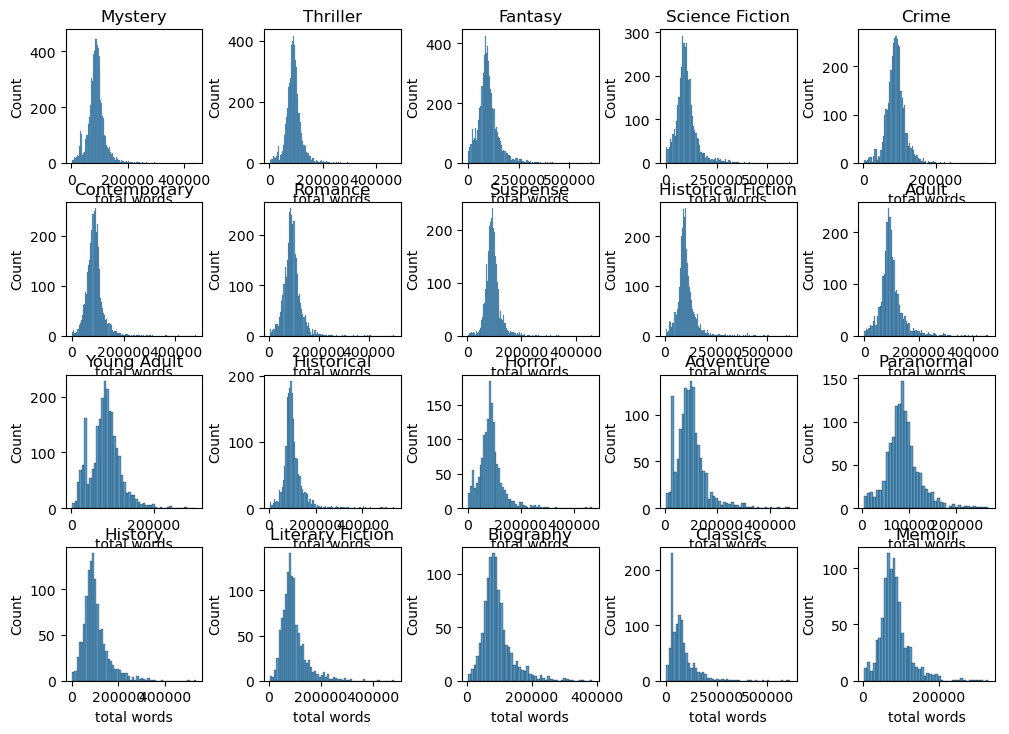

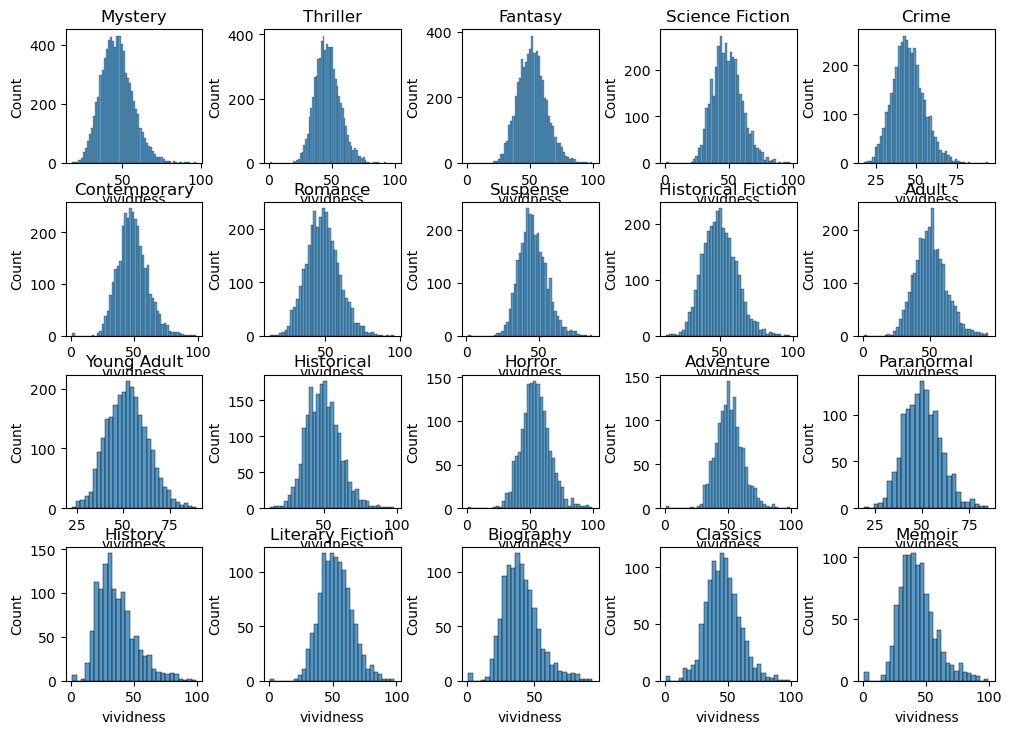

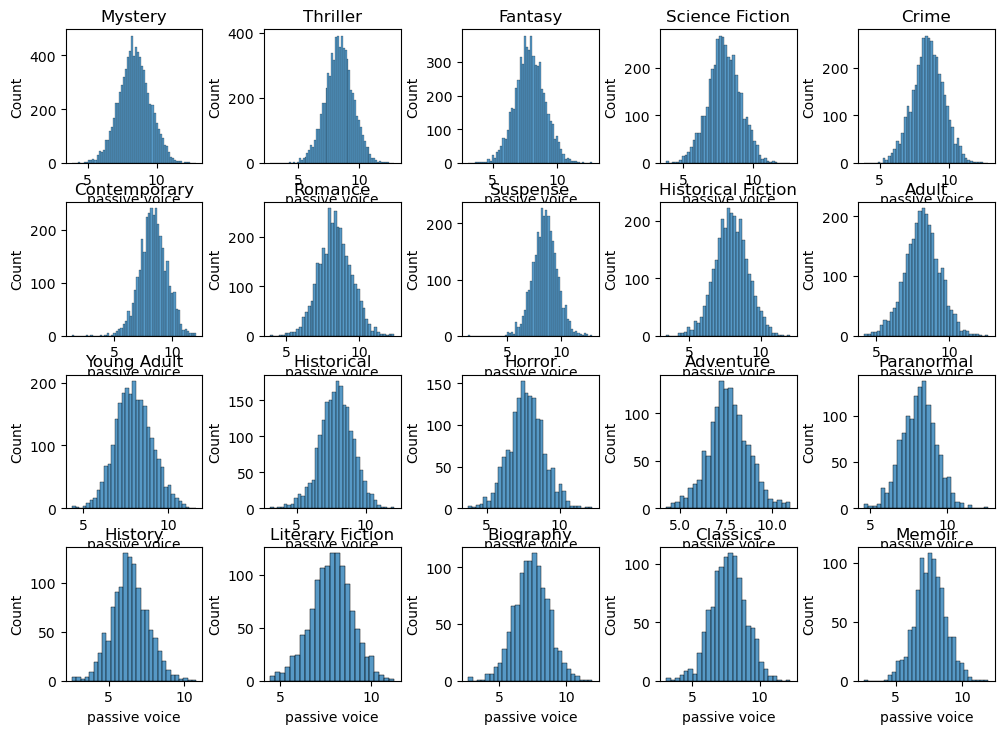

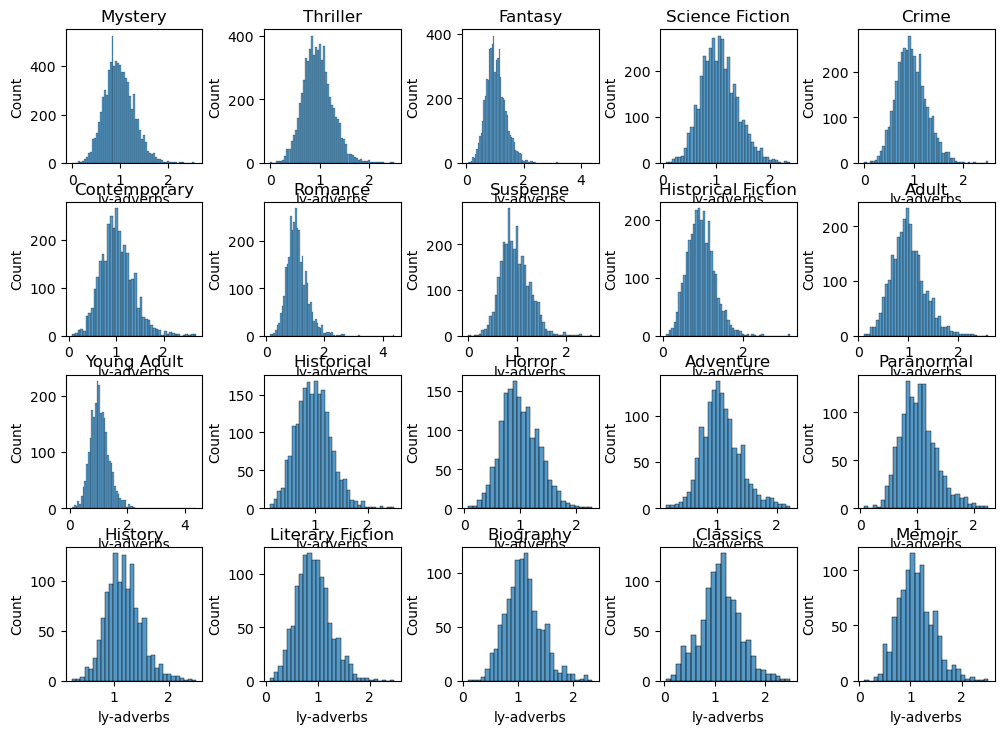

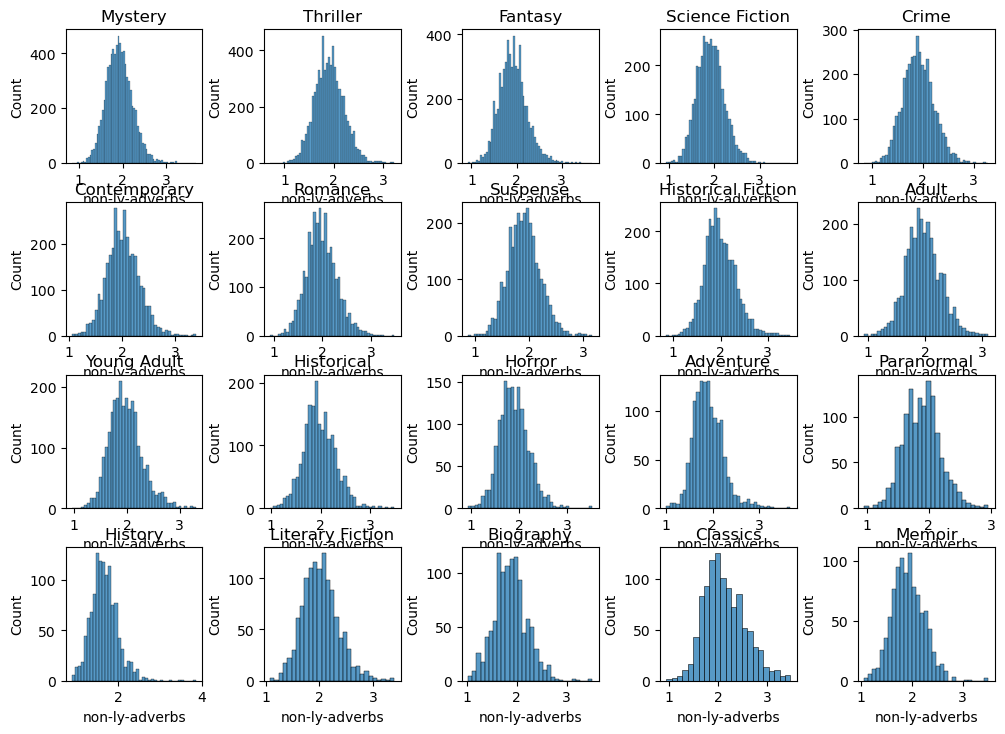

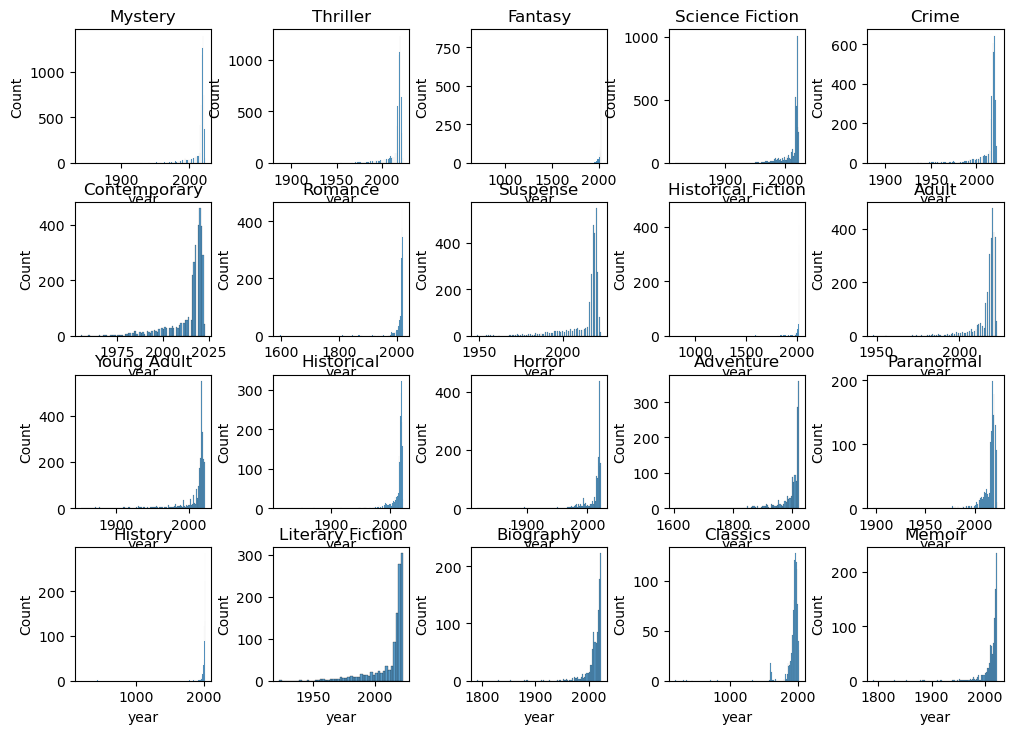

In [127]:
features = ['total words', 'vividness', 'passive voice','ly-adverbs','non-ly-adverbs','year']

for feature in features: 
    plot_feature(df, feature, final_genres)

In [147]:
outdated = ['genre','num genres', 'filtered genres', 'num filtered genres', 'split genres', 'num split genres']
final_df = df.drop(outdated,axis=1).rename({'final genres':'genres'},axis=1)

In [153]:
final_df = final_df[final_df['num final genres'] > 0].reset_index()

In [155]:
final_df.to_csv('../CSVs/8_filtered_genres.csv')